## Imports

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.measure import label, regionprops

sns.set(style="whitegrid")

def load_image(path):
    return np.array(Image.open(path))

def normalize_rgb(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min())

# Loading data
The dataset used for this training is from [CAS Landslide](https://www.nature.com/articles/s41597-023-02847-z). It is a set of:
 - train images + segmentation masks
 - validation images + segmentation masks
 - test images + segmentation masks

In [32]:
# Dataset paths
DATA_DIR = "/kaggle/input/cas-landslide-dataset-png/CAS_Landslide_Dataset_UAV"
x_train_dir = os.path.join(DATA_DIR, "train", "img")
y_train_dir = os.path.join(DATA_DIR, "train", "mask")

x_valid_dir = os.path.join(DATA_DIR, "val", "img")
y_valid_dir = os.path.join(DATA_DIR, "val", "mask")

x_test_dir = os.path.join(DATA_DIR, "test", "img")
y_test_dir = os.path.join(DATA_DIR, "test", "mask")

train_img_files = sorted(glob(os.path.join(x_train_dir, "*.png")))
train_mask_files = sorted(glob(os.path.join(y_train_dir, "*.png")))

valid_img_files = sorted(glob(os.path.join(x_valid_dir, "*.png")))
valid_mask_files = sorted(glob(os.path.join(y_valid_dir, "*.png")))

test_img_files = sorted(glob(os.path.join(x_test_dir, "*.png")))
test_mask_files = sorted(glob(os.path.join(y_test_dir, "*.png")))

Here, the images are in png format, but they still have only 3-channels.

## 1. Image-Level Stats
We’ll analyze:
- Number of images
- Number of masks with and without landslide
- Binary Mask Statistics
- Summary per data split

In [33]:
def dataset_summary(img_files, mask_files, split_name=""):
    print(f"\n📦 {split_name} Split Summary")
    print(f"Total Images: {len(img_files)}")
    
    with_mask = 0
    without_mask = 0
    for f in mask_files:
        mask = load_image(f)
        if mask.ndim == 3:
            mask = mask[:, :, 0]  # binary masks are sometimes RGB (1 channel repeated)
        if np.any(mask):
            with_mask += 1
        else:
            without_mask += 1

    print(f"Images with Landslide: {with_mask}")
    print(f"Images without Landslide: {without_mask}")


In [34]:
dataset_summary(train_img_files, train_mask_files, "Training")
dataset_summary(valid_img_files, valid_mask_files, "Validation")
dataset_summary(test_img_files, test_mask_files, "Test")


📦 Training Split Summary
Total Images: 8753
Images with Landslide: 8753
Images without Landslide: 0

📦 Validation Split Summary
Total Images: 1093
Images with Landslide: 1093
Images without Landslide: 0

📦 Test Split Summary
Total Images: 1093
Images with Landslide: 1093
Images without Landslide: 0


**Binary Mask Statistics**

In [35]:
def binary_mask_stats(mask_files):
    total = 0
    ones = 0
    for f in mask_files:
        mask = load_image(f)
        if mask is None or mask.size == 0:
            print(f"Warning: Skipping empty or invalid mask: {f}")
            continue
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        ones += np.sum(mask)
        total += mask.size

    print(f"Positive pixels (Landslide): {ones}")
    print(f"Negative pixels (No-Landslide): {total - ones}")
    if total > 0:
        print(f"Class balance: {100 * ones / total:.2f}% positive")
    else:
        print("No valid pixels found — unable to compute class balance.")

In [36]:
binary_mask_stats(train_mask_files)

Positive pixels (Landslide): 438544084.0
Negative pixels (No-Landslide): 1856002348.0
Class balance: 19.11% positive


In [37]:
binary_mask_stats(valid_mask_files)

Positive pixels (Landslide): 53232909.0
Negative pixels (No-Landslide): 233290483.0
Class balance: 18.58% positive


In [38]:
binary_mask_stats(test_mask_files)

Positive pixels (Landslide): 51867524.0
Negative pixels (No-Landslide): 234655868.0
Class balance: 18.10% positive


## 2. Pixel-Level Intensity Distribution
We'll compute:
- Mean and Std per channel
- Histogram per channel (RGB)

In [41]:
def compute_stats(img_files):
    means, stds = [], []
    for f in img_files:
        img = load_image(f)
        means.append(np.mean(img, axis=(0, 1)))
        stds.append(np.std(img, axis=(0, 1)))
    return np.mean(means, axis=0), np.mean(stds, axis=0)

means, stds = compute_stats(train_img_files)
print("\n🎨 Channel Stats (Train Set):")
for i in range(3):
    print(f"Channel {i}: Mean = {means[i]:.2f}, Std = {stds[i]:.2f}")


🎨 Channel Stats (Train Set):
Channel 0: Mean = 87.81, Std = 52.00
Channel 1: Mean = 87.41, Std = 49.18
Channel 2: Mean = 76.35, Std = 47.80


**Histogram of All Channels**

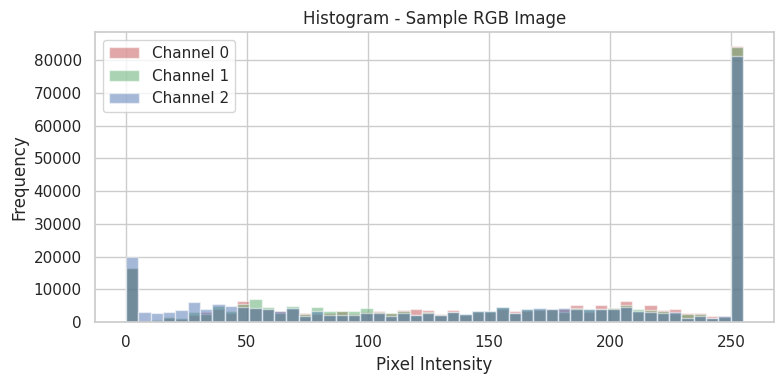

In [42]:
def plot_channel_histogram(image, title="Image"):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(8, 4))
    for i in range(3):
        plt.hist(image[:, :, i].flatten(), bins=50, color=colors[i], alpha=0.5, label=f'Channel {i}')
    plt.title(f"Histogram - {title}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example
sample_img = load_image(train_img_files[0])
plot_channel_histogram(sample_img, title="Sample RGB Image")

## 3. RGB Composite & Mask Visualization
We’ll show:
- The RGB image
- The landslide mask overlayed on top

In [43]:
def visualize_multiple_images_with_masks(img_paths, mask_paths, n=5):
    import matplotlib.pyplot as plt

    # Create subplots: n rows, 2 columns
    fig, axes = plt.subplots(n, 2, figsize=(12, 4 * n))  # Increase height per row

    for i in range(n):
        img = load_image(img_paths[i])
        mask = load_image(mask_paths[i])
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        rgb = normalize_rgb(img)

        # Show RGB image
        ax_img = axes[i, 0]
        ax_img.imshow(rgb)
        ax_img.set_title(f"Image {i+1}")
        ax_img.axis("off")

        # Show RGB + Mask overlay
        ax_mask = axes[i, 1]
        ax_mask.imshow(rgb)
        ax_mask.imshow(mask, cmap='Reds', alpha=0.4)
        ax_mask.set_title(f"Image with Landslide Mask {i+1}")
        ax_mask.axis("off")

    plt.subplots_adjust(wspace=0.05, hspace=0.15)  # Reduce horizontal gap between columns
    plt.tight_layout()
    plt.show()


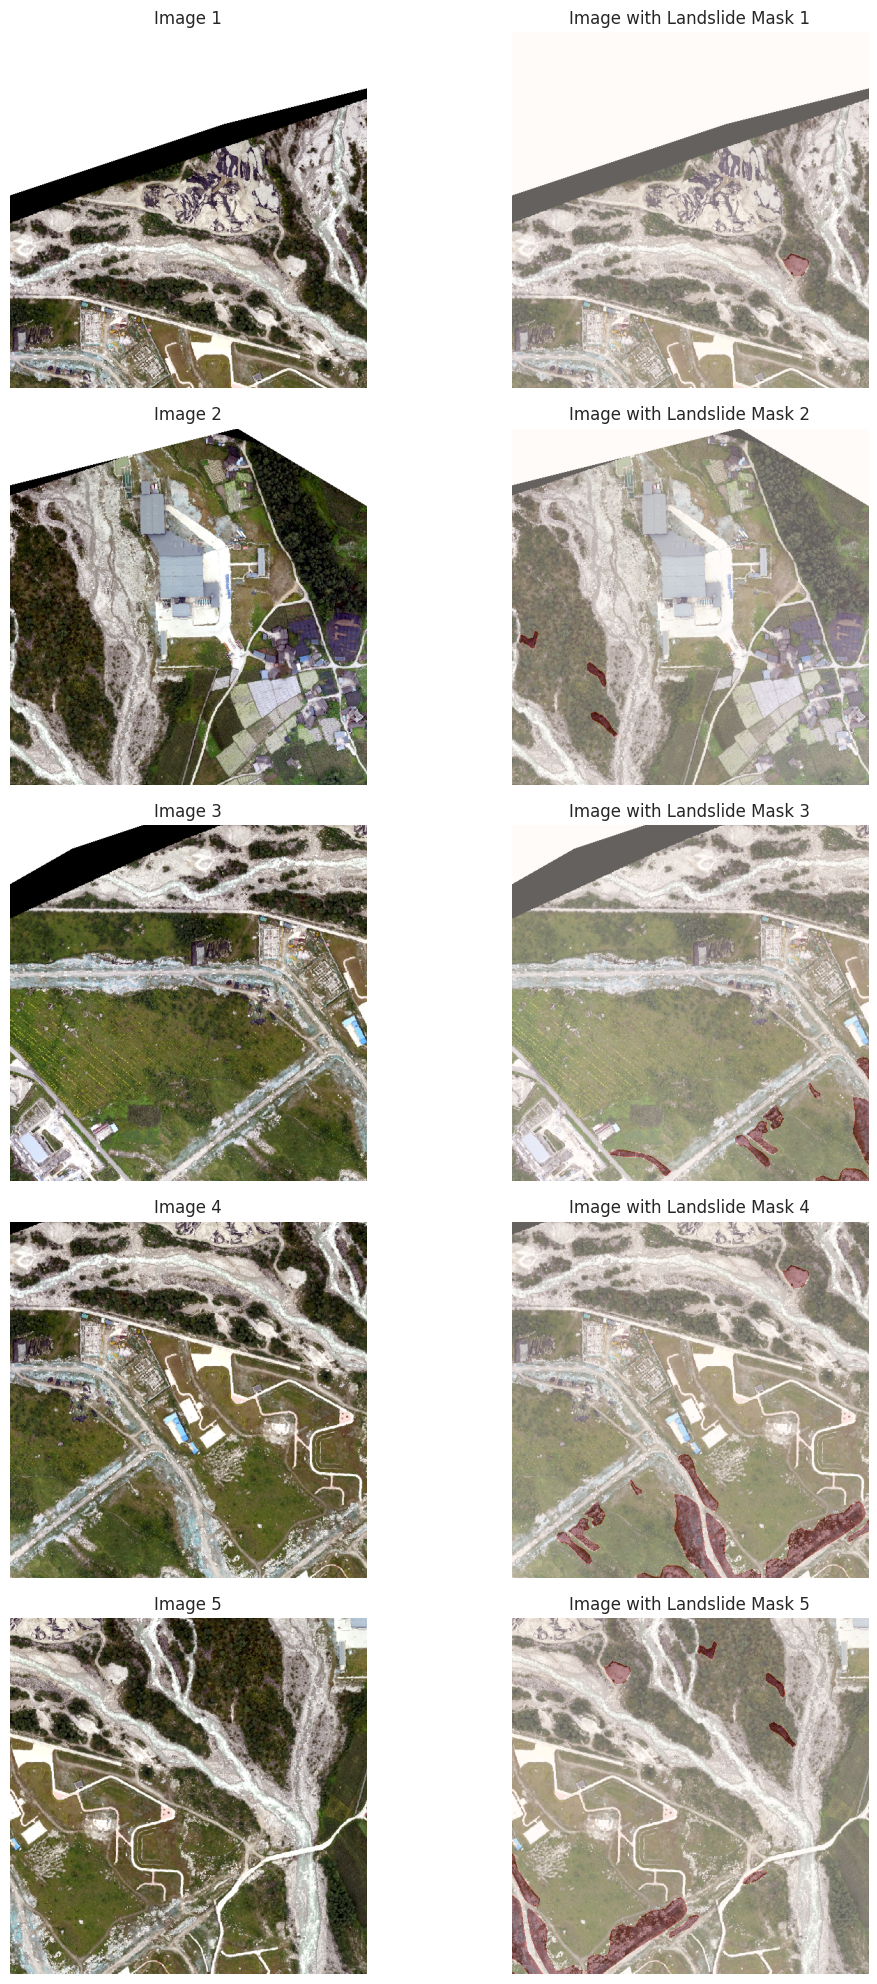

In [44]:
visualize_multiple_images_with_masks(train_img_files, train_mask_files, n=5)